# Deep neural net to predict user ratings
### Outline
- Map user ID to a "user vector" via an embedding matrix
- Map movie ID to a "movie vector" via an embedding matrix
- Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
- Train the embeddings via gradient descent using all known user-movie pairs to learn the ratings
- To recommend new movies for a user, find the movies not watched by the user, and use prediction to get possible user ratings on unwatched movies
- Select top highly rated movies 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

## Read users,ratings and movies files

In [4]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/movieLense'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [5]:
# Utility function to read files
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [6]:
# Utility function to Write files
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [7]:
import re

def remove_special_characters(text):
    '''Function to clean up any given text by removing non alphanumeric characters with spaces'''
    # Define a pattern to keep only alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Use the pattern to replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

### Users

In [8]:
users = read_file('users.csv')

In [9]:
users.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Ratings

In [10]:
ratings = read_file('ratings_short.csv')

In [11]:
ratings.head()

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4


### Movies

In [12]:
movies = read_file('movies_combined_cleaned_title.csv')

In [13]:
movies.head()

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",fourrooms
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri...",getshorty
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph...",copycat


### Basic checks

In [14]:
# Check for the shape of each users, item(movies) and ratings
users.shape
ratings.shape
movies.shape

(943, 5)

(99383, 4)

(1663, 26)

In [15]:
# Check for duplications
users.duplicated().sum()
ratings.duplicated().sum()
movies.duplicated().sum()

0

0

0

## Preprocessing
As we are going to build a matrix of users and movies rated by them, we will have to do some preprocessing to retain original indexes
Numeric indices are often more convenient for array-based operations and indexing. They can be useful when working with frameworks like NumPy or TensorFlow/Keras, where numeric indices are commonly used. However consideration should be given to the fact that numeric indices might not have inherent meaning and might not be as interpretable as IDs.

### Users from Ratings file

In [16]:
ratings.head()

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4


In [17]:
# Get the list of user ids who have rated the movies
user_ids = ratings["user_id"].unique().tolist()

In [18]:
# Enumerate the user id list to retain their indices => Given a user, allows to retrieve index
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_encoded
# Retrieve index for user 42 (user_id,index)
user2user_encoded[42]

{1: 0,
 2: 1,
 5: 2,
 6: 3,
 10: 4,
 13: 5,
 15: 6,
 16: 7,
 17: 8,
 18: 9,
 20: 10,
 21: 11,
 23: 12,
 25: 13,
 26: 14,
 38: 15,
 41: 16,
 42: 17,
 43: 18,
 44: 19,
 45: 20,
 49: 21,
 54: 22,
 56: 23,
 57: 24,
 58: 25,
 59: 26,
 62: 27,
 63: 28,
 64: 29,
 65: 30,
 66: 31,
 67: 32,
 70: 33,
 72: 34,
 73: 35,
 75: 36,
 77: 37,
 79: 38,
 81: 39,
 82: 40,
 83: 41,
 84: 42,
 89: 43,
 92: 44,
 93: 45,
 94: 46,
 95: 47,
 96: 48,
 97: 49,
 99: 50,
 101: 51,
 102: 52,
 106: 53,
 108: 54,
 109: 55,
 117: 56,
 120: 57,
 121: 58,
 124: 59,
 125: 60,
 128: 61,
 130: 62,
 131: 63,
 134: 64,
 137: 65,
 138: 66,
 141: 67,
 144: 68,
 145: 69,
 148: 70,
 150: 71,
 151: 72,
 157: 73,
 158: 74,
 160: 75,
 162: 76,
 168: 77,
 174: 78,
 177: 79,
 178: 80,
 181: 81,
 182: 82,
 184: 83,
 189: 84,
 193: 85,
 194: 86,
 198: 87,
 199: 88,
 200: 89,
 201: 90,
 202: 91,
 203: 92,
 204: 93,
 209: 94,
 210: 95,
 213: 96,
 216: 97,
 222: 98,
 223: 99,
 230: 100,
 231: 101,
 232: 102,
 234: 103,
 235: 104,
 242: 105,

17

In [19]:
# Create a list of index and users ids => Given an index, returns the user id
userencoded2user = {i: x for i, x in enumerate(user_ids)}
userencoded2user
# Retrive user based on index (index,user_id)

{0: 1,
 1: 2,
 2: 5,
 3: 6,
 4: 10,
 5: 13,
 6: 15,
 7: 16,
 8: 17,
 9: 18,
 10: 20,
 11: 21,
 12: 23,
 13: 25,
 14: 26,
 15: 38,
 16: 41,
 17: 42,
 18: 43,
 19: 44,
 20: 45,
 21: 49,
 22: 54,
 23: 56,
 24: 57,
 25: 58,
 26: 59,
 27: 62,
 28: 63,
 29: 64,
 30: 65,
 31: 66,
 32: 67,
 33: 70,
 34: 72,
 35: 73,
 36: 75,
 37: 77,
 38: 79,
 39: 81,
 40: 82,
 41: 83,
 42: 84,
 43: 89,
 44: 92,
 45: 93,
 46: 94,
 47: 95,
 48: 96,
 49: 97,
 50: 99,
 51: 101,
 52: 102,
 53: 106,
 54: 108,
 55: 109,
 56: 117,
 57: 120,
 58: 121,
 59: 124,
 60: 125,
 61: 128,
 62: 130,
 63: 131,
 64: 134,
 65: 137,
 66: 138,
 67: 141,
 68: 144,
 69: 145,
 70: 148,
 71: 150,
 72: 151,
 73: 157,
 74: 158,
 75: 160,
 76: 162,
 77: 168,
 78: 174,
 79: 177,
 80: 178,
 81: 181,
 82: 182,
 83: 184,
 84: 189,
 85: 193,
 86: 194,
 87: 198,
 88: 199,
 89: 200,
 90: 201,
 91: 202,
 92: 203,
 93: 204,
 94: 209,
 95: 210,
 96: 213,
 97: 216,
 98: 222,
 99: 223,
 100: 230,
 101: 231,
 102: 232,
 103: 234,
 104: 235,
 105: 242,

In [20]:
# Store the index of user ids enumerated
ratings["user"] = ratings["user_id"].map(user2user_encoded)

In [21]:
ratings.head()

,user_id,movie_id,imdb_id,rating,user
0,1,1,tt0114709,5,0
1,2,1,tt0114709,4,1
2,5,1,tt0114709,4,2
3,6,1,tt0114709,4,3
4,10,1,tt0114709,4,4


### Movies from Ratings file

In [22]:
# Extract all movies which have been rated
movie_ids = ratings["movie_id"].unique().tolist()

In [23]:
# Enumerate the movie id list to retain their indices => Given a movie, allows to retrieve index

movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie2movie_encoded
# Returns index of movie (movie_id,index)
movie2movie_encoded[34]

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

33

In [24]:
# Create a list of index and movie ids => Given an index, returns the movie id
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
movie_encoded2movie
# Returns the movie for an index (index,movie_id)
movie_encoded2movie[7]

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

8

In [25]:
# Store the index of movie ids enumerated
ratings["movie"] = ratings["movie_id"].map(movie2movie_encoded)

In [26]:
ratings.head(3)

,user_id,movie_id,imdb_id,rating,user,movie
0,1,1,tt0114709,5,0,0
1,2,1,tt0114709,4,1,0
2,5,1,tt0114709,4,2,0


In [27]:
# Number of unique users and movies
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
num_users
num_movies

943

1663

In [28]:
# Ratings are converted to float
ratings["rating"] = ratings["rating"].values.astype(np.float32)

In [29]:
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
min_rating
max_rating

1.0

5.0

In [30]:
# Summary
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1663, Min rating: 1.0, Max rating: 5.0


## Prepare training and validation Data

In [31]:
#  randomly select a specified number of items or a fraction of items from a DataFrame
# fract = 1 => 100% of rows and nal but is used to ensure reproducibility. Setting a specific random state ensures that the random
# selections are the same every time we run the script, making it easier to reproduce results.
df = ratings.sample(frac=1, random_state=42)

In [32]:
df.shape

(99383, 6)

In [33]:
df.head(5)

,user_id,movie_id,imdb_id,rating,user,movie
80710,450,725,tt0109758,3.000,212,717
65922,622,506,tt0048545,3.000,293,500
59806,145,436,tt0082010,5.000,69,431
84406,643,780,tt0109686,4.000,302,772
35594,619,231,tt0103776,4.000,688,230


In [34]:
#Store original indices as inputs
x = df[["user", "movie"]].values

In [35]:
x

array([[212, 717],
       [293, 500],
       [ 69, 431],
       ...,
       [556, 656],
       [477,   3],
       [221, 113]])

In [36]:
# Normalization helps ensure that features are on a similar scale, which can
# improve the convergence of optimization algorithms and the overall performance of the model
# Normalize the targets between 0 and 1. Makes it easy to train and store as Y
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([0.5 , 0.5 , 1.  , ..., 1.  , 1.  , 0.75])

In [37]:
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [38]:
x_train.shape
y_train.shape
x_val.shape
y_val.shape

(89444, 2)

(89444,)

(9939, 2)

(9939,)

In [39]:
# As model will take 2 inputs, split the input user input and movie input
x_train_users=[]
for i in range(len(x_train)):
    x_train_users.append(x_train[i][0])

x_train_movies=[]
for i in range(len(x_train)):
    x_train_movies.append(x_train[i][1])

In [40]:
# Same will be done for validation input
x_val_users=[]
for i in range(len(x_val)):
    x_val_users.append(x_val[i][0])

x_val_movies=[]
for i in range(len(x_val)):
    x_val_movies.append(x_val[i][1])

## Create the model
We embed both users and movies in to 50-dimensional vectors.
The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias.
The match score is scaled to the [0, 1] interval via a sigmoid

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout,Dot,Flatten,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim=50

# User input
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users,embeddings_initializer="he_normal", output_dim=embedding_dim, input_length=1,embeddings_regularizer=l2(1e-6))(user_input)
user_embedding = Flatten()(user_embedding)

# User bias
user_bias = Embedding(input_dim=num_users, output_dim=1, input_length=1)(user_input)
user_bias = Flatten()(user_bias)

# Movie input
movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=num_movies,embeddings_initializer="he_normal", output_dim=embedding_dim, input_length=1,embeddings_regularizer=l2(1e-6))(movie_input)
movie_embedding = Flatten()(movie_embedding)

# Movie bias
movie_bias = Embedding(input_dim=num_movies, output_dim=1, input_length=1)(movie_input)
movie_bias = Flatten()(movie_bias)

# Concatenate or multiply user and item embeddings
dot_product = Dot(axes=1)([user_embedding, movie_embedding])
# interaction_layer = Multiply()([user_embedding, item_embedding])  # Example with element-wise product

# Add user and movie biases
interaction = Add()([dot_product, user_bias, movie_bias])

# Feedforward neural network
dense_layer = Dense(1, activation='relu',kernel_regularizer=l2(0.001))(interaction)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[user_input, movie_input], outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                47150     ['user_input[0][0]']          
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 50)                83150     ['movie_input[0][0]']         
                                                                                              

2023-12-26 14:39:15.198354: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-26 14:39:15.198384: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-26 14:39:15.198394: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-26 14:39:15.198639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-26 14:39:15.199003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train the model based on the data split

In [44]:
# Convert to numpy array
user_train_input_data = np.array(x_train_users)
movie_train_input_data = np.array(x_train_movies)
user_val_input_data = np.array(x_val_users)
movie_val_input_data = np.array(x_val_movies)
ratings_train_input_data = np.array(y_train)
ratings_val_input_data = np.array(y_val)

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [46]:
history = model.fit(
    x=[user_train_input_data,movie_train_input_data],
    y=ratings_train_input_data,
    batch_size=64,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=([user_val_input_data,movie_val_input_data], ratings_val_input_data),
)

Epoch 1/5


2023-12-26 14:39:58.476824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1398/1398 [==============================] - 34s 24ms/step - loss: 0.6850 - accuracy: 0.2119 - val_loss: 0.6778 - val_accuracy: 0.2133
Epoch 2/5
1398/1398 [==============================] - 33s 24ms/step - loss: 0.6726 - accuracy: 0.2119 - val_loss: 0.6684 - val_accuracy: 0.2133
Epoch 3/5
1398/1398 [==============================] - 33s 24ms/step - loss: 0.6650 - accuracy: 0.2119 - val_loss: 0.6627 - val_accuracy: 0.2133
Epoch 4/5
1398/1398 [==============================] - 33s 23ms/step - loss: 0.6604 - accuracy: 0.2119 - val_loss: 0.6593 - val_accuracy: 0.2133
Epoch 5/5
1398/1398 [==============================] - 33s 24ms/step - loss: 0.6574 - accuracy: 0.2119 - val_loss: 0.6568 - val_accuracy: 0.2133


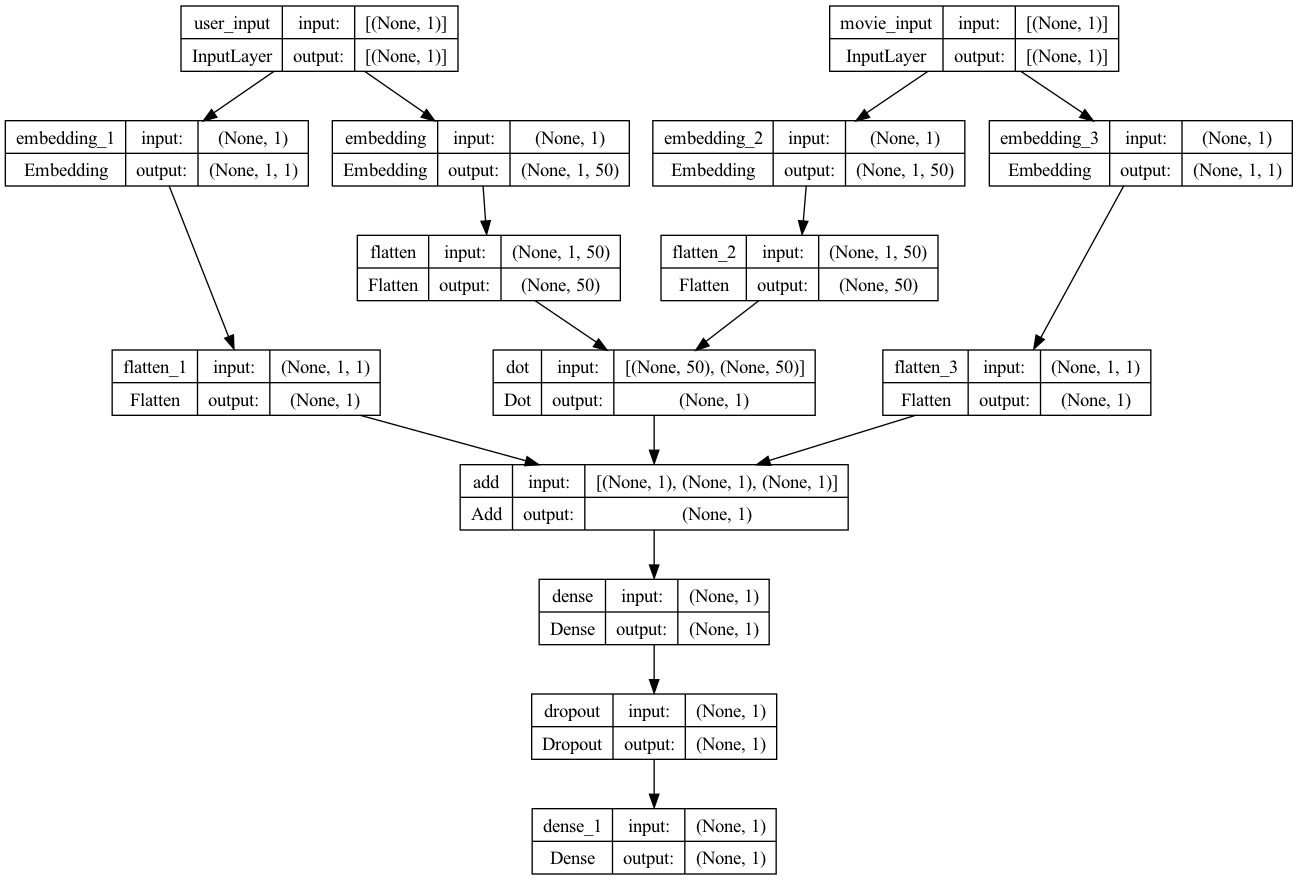

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Plot training and validation loss

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

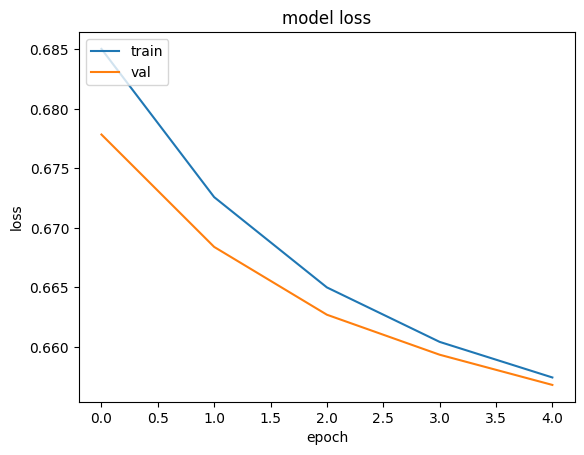

In [48]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Show top 10 movie recommendations to a user

In [49]:
# Let us get a user and see the top recommendations.
#randomly select a user from ratings df
user_id = df.user_id.sample(1).iloc[0]
# Movies watched by this user
movies_watched_by_user = df[df.user_id == user_id]
print("movies watched by the user: " + str(movies_watched_by_user.shape[0]))

# Movies not watched by this user from the main movies df
movies_not_watched = movies[
    ~movies["ml_id"].isin(movies_watched_by_user.movie_id.values)
]["ml_id"]
print("Total movies in DB: " + str(movies.shape[0]))
print("movies not watched by the user: " + str(movies_not_watched.shape[0]))

# extract movies from not watch list that other users have rated
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
# extract the index of these
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# get user index
user_encoder = user2user_encoded.get(user_id)

user_input = np.array([[user_encoder]] * len(movies_not_watched))
movies_input = np.array(movies_not_watched)

# Predict the ratings which may be given by this user to movies not watched
user_ratings = model.predict([user_input,movies_input]).flatten()

# Select top 10 movies with highest ratings
top_ratings_indices = user_ratings.argsort()[-10:][::-1]
# Get the original movie ids for recommended movies
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movies[movies["ml_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title) #,":" ,row.genres

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies[movies["ml_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title) #,":" ,row.genres

movies watched by the user: 42
Total movies in DB: 1663
movies not watched by the user: 1621
51/51 [==============================] - 0s 4ms/step
Showing recommendations for user: 589
Movies with high ratings from user
--------------------------------
Good Will Hunting 
Mad City 
Anastasia 
Picture Perfect 
Scream 2 
--------------------------------
Top 10 movie recommendations
--------------------------------
Wes Craven's New Nightmare 
Speed 
Wolf 
Wyatt Earp 
Another Stakeout 
Blown Away 
Body Snatchers 
Boxing Helena 
Coneheads 
Scream of Stone 


# Hyperparameter Tunning
Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. 
Here we will use Hyperband tuner.

In [52]:
import keras_tuner as kt

In [53]:
def model_final_builder(hp):
    hp_embedding_dim= hp.Choice('embedding_dim', values=[20,50,80])
    hp_embeddings_regularizer = hp.Choice('embeddings_regularizer', values=[1e-4, 1e-5,1e-6])
    # User input
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(input_dim=num_users,embeddings_initializer="he_normal", output_dim=hp_embedding_dim, input_length=1,embeddings_regularizer=l2(hp_embeddings_regularizer))(user_input)
    user_embedding = Flatten()(user_embedding)

    # User bias
    user_bias = Embedding(input_dim=num_users, output_dim=1, input_length=1)(user_input)
    user_bias = Flatten()(user_bias)

    # Movie input
    movie_input = Input(shape=(1,), name='movie_input')
    movie_embedding = Embedding(input_dim=num_movies,embeddings_initializer="he_normal", output_dim=hp_embedding_dim, input_length=1,embeddings_regularizer=l2(hp_embeddings_regularizer))(movie_input)
    movie_embedding = Flatten()(movie_embedding)

    # Movie bias
    movie_bias = Embedding(input_dim=num_movies, output_dim=1, input_length=1)(movie_input)
    movie_bias = Flatten()(movie_bias)

    # Concatenate or multiply user and item embeddings
    dot_product = Dot(axes=1)([user_embedding, movie_embedding])
    # interaction_layer = Multiply()([user_embedding, item_embedding])  # Example with element-wise product

    # Add user and movie biases
    interaction = Add()([dot_product, user_bias, movie_bias])


    # Feedforward neural network
    hp_units = hp.Int('units', min_value=1, max_value=64, step=32)
    hp_activation=hp.Choice('activation_func_D1',values=['relu','sigmoid',])
    hp_kernel_regularizer = hp.Choice('kernel_regularizer', values=[0.01,0.001,0.0001])

    dense_layer = Dense(hp_units, activation=hp_activation,kernel_regularizer=l2(hp_kernel_regularizer))(interaction)

    hp_drop_rate= hp.Choice('drop_rate', values=[0.2,0.3,0.4,0.5])
    dense_layer = Dropout(hp_drop_rate)(dense_layer)

    output_layer = Dense(1, activation='softmax')(dense_layer)

    # Create the model
    model_hp = Model(inputs=[user_input, movie_input], outputs=output_layer)

    # Compile the model
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model_hp.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Display the model architecture
    return model_hp

In [83]:
# Instantiate the tuner to perform the hypertuning.
tuner_HB = kt.Hyperband(model_final_builder,
                     objective='val_loss',
                     max_epochs=5, # Maximum epochs for each configuration in a bracket
                     hyperband_iterations=1,
                     factor=5,
                     distribution_strategy=tf.distribute.MirroredStrategy(),
                     overwrite=True,
                     directory='/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/notebooks/03_Models',
                     project_name='DNN_ratings_prediction')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [86]:
tuner_HB.search([user_train_input_data,movie_train_input_data],
                ratings_train_input_data,
                steps_per_epoch=600,
                epochs=10,
                validation_data=([user_val_input_data,movie_val_input_data], ratings_val_input_data),
                validation_steps=100,
                callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps_HB=tuner_HB.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete for Hyperband.
""")

Trial 7 Complete [00h 11m 03s]
val_loss: 0.6625159382820129

Best val_loss So Far: 0.6096525192260742
Total elapsed time: 00h 25m 30s

The hyperparameter search is complete for Hyperband.



In [91]:
best_hps_HB.values

{'embedding_dim': 80,
 'embeddings_regularizer': 1e-05,
 'units_1': 33,
 'activation_func_D1': 'relu',
 'kernel_regularizer': 0.001,
 'drop_rate': 0.2,
 'learning_rate': 0.001,
 'tuner/epochs': 1,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

# Train the model on best hyper parameters

In [96]:
# Build the model with the optimal hyperparameters and train it on the training dataset for 15 epochs
model = tuner_HB.hypermodel.build(best_hps_HB)
history = model.fit(
    x=[user_train_input_data,movie_train_input_data],
    y=ratings_train_input_data,
    batch_size=64,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=([user_val_input_data,movie_val_input_data], ratings_val_input_data),
)

train_loss_per_epoch = history.history['loss']
best_epoch = train_loss_per_epoch.index(max(train_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/5
1398/1398 [==============================] - 230s 160ms/step - loss: 0.6285 - accuracy: 0.2119 - val_loss: 0.6079 - val_accuracy: 0.2133
Epoch 2/5
1398/1398 [==============================] - 231s 166ms/step - loss: 0.5791 - accuracy: 0.2119 - val_loss: 0.6118 - val_accuracy: 0.2133
Best epoch: 1


In [97]:
# Build the model with the optimal hyperparameters and train it on the training dataset for 15 epochs
model = tuner_HB.hypermodel.build(best_hps_HB)
history = model.fit(
    x=[user_train_input_data,movie_train_input_data],
    y=ratings_train_input_data,
    batch_size=64,
    epochs=1,
    verbose=1,
    callbacks=[early_stopping],
    validation_data=([user_val_input_data,movie_val_input_data], ratings_val_input_data),
)

1398/1398 [==============================] - 251s 177ms/step - loss: 0.6264 - accuracy: 0.2119 - val_loss: 0.6072 - val_accuracy: 0.2133


In [98]:
import pickle
pickle.dump(model,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/dnn_ratings_pred.pkl','wb'))

In [114]:
model.export("/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/")

INFO:tensorflow:Assets written to: /Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/assets


INFO:tensorflow:Assets written to: /Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/assets


Saved artifact at '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: [<1>, <2>]
      <1>: float32 Tensor, shape=(None, 1)
      <2>: float32 Tensor, shape=(None, 1)
  Returns:
    float32 Tensor, shape=(None, 1)


In [115]:
pickle.dump(df,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/dnn_ratings_pred_df.pkl','wb'))
pickle.dump(movie2movie_encoded,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/dnn_movie2movie_encoded.pkl','wb'))
pickle.dump(user2user_encoded,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/dnn_user2user_encoded.pkl','wb'))
pickle.dump(movie_encoded2movie,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/DNN_ratings_prediction/dnn_movie_encoded2movie.pkl','wb'))

In [118]:
# Let us get a user and see the top recommendations.
#randomly select a user from ratings df
# user_id = df.user_id.sample(1).iloc[0]
# Movies watched by this user
user_id=6
movies_watched_by_user = df[df.user_id == user_id]
print("movies watched by the user: " + str(movies_watched_by_user.shape[0]))

# Movies not watched by this user from the main movies df
movies_not_watched = movies[
    ~movies["ml_id"].isin(movies_watched_by_user.movie_id.values)
]["ml_id"]
print("Total movies in DB: " + str(movies.shape[0]))
print("movies not watched by the user: " + str(movies_not_watched.shape[0]))

# extract movies from not watch list that other users have rated
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
# extract the index of these
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# get user index
user_encoder = user2user_encoded.get(user_id)

user_input = np.array([[user_encoder]] * len(movies_not_watched))
movies_input = np.array(movies_not_watched)

# Predict the ratings which may be given by this user to movies not watched
user_ratings = model.predict([user_input,movies_input]).flatten()

# Select top 10 movies with highest ratings
top_ratings_indices = user_ratings.argsort()[-10:][::-1]
print(top_ratings_indices)
# Get the original movie ids for recommended movies
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movies[movies["ml_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title) #,":" ,row.genres

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies[movies["ml_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title) #,":" ,row.genres

movies watched by the user: 208
Total movies in DB: 1663
movies not watched by the user: 1455
46/46 [==============================] - 1s 23ms/step
[1454  477  479  480  481  482  483  484  485  486]
Showing recommendations for user: 6
Movies with high ratings from user
--------------------------------
Jean de Florette 
When Harry Met Sally... 
Casablanca 
Sunset Blvd. 
Big Sleep, The 
--------------------------------
Top 10 movie recommendations
--------------------------------
Casino 
Kicking and Screaming 
City Hall 
Basketball Diaries, The 
Browning Version, The 
Little Women 
Miami Rhapsody 
Wonderful, Horrible Life of Leni Riefenstahl, The 
Barcelona 
Scream of Stone 


In [108]:
recommended_movies

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
624,630,"Great Race, The",1965,tt0059243,0,0,0,0,0,1,...,1,0,0,0,0,0,0,The Great Leslie and Professor Fate are comp...,"[{""category"":""editor"",""crew_name"":""Ralph E. Wi...",greatracethe
625,631,"Crying Game, The",1992,tt0104036,0,1,0,0,0,0,...,0,0,1,0,0,1,0,The film opens as a psychological thriller â...,"[{""category"":""production_designer"",""crew_name""...",cryinggamethe
626,632,Sophie's Choice,1982,tt0084707,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"In 1947, the movie's narrator, Stingo , reloca...","[{""category"":""editor"",""crew_name"":""Evan A. Lot...",sophieschoice
627,633,"Christmas Carol, A",1938,tt0001544,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,"[{""category"":""actress"",""crew_name"":""Shirley Ma...",christmascarola
628,634,Microcosmos: Le peuple de l'herbe,1996,tt0117040,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,"[{""category"":""editor"",""crew_name"":""Marie-Jos\u...",microcosmoslepeupledelherbe
629,635,"Fog, The",1980,tt0006230,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,"[{""category"":""actress"",""crew_name"":""Florence S...",fogthe
630,636,Escape from New York,1981,tt0082340,0,1,1,0,0,0,...,0,0,0,1,1,0,0,"In a dystopian 1988, crime in the United State...","[{""category"":""cinematographer"",""crew_name"":""De...",escapefromnewyork
631,637,"Howling, The",1981,tt0024958,0,0,0,0,0,1,...,0,0,0,0,0,0,0,"Arthur Cartwright, an anxious man, goes to Per...","[{""category"":""actress"",""crew_name"":""Helen Tren...",howlingthe
633,639,"Tin Drum, The",1979,tt0078875,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"The film begins in 1899, with the grandfather ...","[{""category"":""composer"",""crew_name"":""Friedrich...",tindrumthe
1662,1682,Scream of Stone,1996,tt0102855,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,"[{""category"":""producer"",""crew_name"":""Henry Lan...",screamofstone


In [107]:
df[df['user_id']==42].sort_values('rating',ascending=False)

,user_id,movie_id,imdb_id,rating,user,movie
4611,42,28,tt0112384,5.000,17,27
71981,42,588,tt0000225,5.000,17,582
11980,42,88,tt0108160,5.000,17,87
35314,42,230,tt0092007,5.000,17,229
28925,42,194,tt0006012,5.000,17,193
...,...,...,...,...,...,...
86269,42,834,tt0113253,1.000,17,826
93634,42,1048,tt0002409,1.000,17,1037
42264,42,276,tt0113627,1.000,17,273
57251,42,413,tt0117826,1.000,17,408


In [126]:
# Create a numpy array
arr = np.array([13, 2, 9,1])

# Get the indices that would sort the array in descending order
indices_ascending = np.argsort(arr)
print(indices_ascending)

indices_descending = np.argsort(arr)[::-1]
print(indices_descending)
# Select the top 10 indices
top_10_indices = indices_descending[:2]
top_10_values = arr[indices_descending]

print(top_10_values)

print("Original array:", arr)
print("Indices of the top 10 records in descending order:", top_10_indices)

[3 1 2 0]
[0 2 1 3]
[13  9  2  1]
Original array: [13  2  9  1]
Indices of the top 10 records in descending order: [0 2]
